In [ ]:
!pip install pm4py

drive = True
dir = './data/'
if drive:
  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  import sys
  sys.path.insert(0,'/content/drive/My Drive/Masterthesis')

  dir = '/content/drive/My Drive/Masterthesis/data'

import pandas as pd
import numpy as np
import pm4py

In [83]:
def import_xes(file_path):
    event_log = pm4py.read_xes(file_path)
    event_log['time:timestamp'] = pd.to_datetime(event_log['time:timestamp'], utc=True)
    return event_log

event_log_original = import_xes(dir + '/Hospital_log.xes')
event_log_modified = import_xes(dir + '/Hospital_log_modified.xes') # dutch activity names are replaced by english names
event_log_case_specific = pd.read_csv(dir + 'event_log_case_specific.csv', index_col=0)

parsing log, completed traces ::   0%|          | 0/1143 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1143 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pm4py/objects/conversion/log/variants/to_data_frame.py:76: FutureWarning: Inferring datetime64[ns, UTC+01:00] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns, UTC+01:00])
  df = pd.DataFrame.from_dict(transf_log)


In [70]:
# Remove cols
relevant_cols = ['Activity code', 'time:timestamp', 'concept:name', 'case:concept:name']
df_for_pm = event_log_modified.loc[:, relevant_cols].copy()

# Reduce size
df_for_pm['Events per case'] = df_for_pm.groupby(by='case:concept:name')['case:concept:name'].transform('size')
df_for_pm.loc[:, 'case:concept:name'] = df_for_pm.loc[:, 'case:concept:name'].apply(int)
df_for_pm = df_for_pm[df_for_pm['Events per case']<=8].copy()

# Change data types to string
df_for_pm['case:concept:name'] = df_for_pm['case:concept:name'].astype('str')
df_for_pm['Activity code'] = df_for_pm['Activity code'].astype('str')
df_for_pm['concept:name'] = df_for_pm['concept:name'].astype('str')

print("Traces included: {}".format(df_for_pm['case:concept:name'].drop_duplicates().count()))

df_for_pm

Traces included: 288


<ipython-input-70-66481d910ae4>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_for_pm.loc[:, 'case:concept:name'] = df_for_pm.loc[:, 'case:concept:name'].apply(int)


Activity code            time:timestamp  \
1195           10307 2005-01-07 23:00:00+00:00   
1196          411100 2005-01-12 23:00:00+00:00   
1197          419100 2005-01-12 23:00:00+00:00   
1198          370000 2005-04-03 23:00:00+00:00   
1199        376400.0 2005-04-03 23:00:00+00:00   
...              ...                       ...   
150046        370000 2008-03-04 23:00:00+00:00   
150047       378619A 2008-03-04 23:00:00+00:00   
150048        379999 2008-03-04 23:00:00+00:00   
150049        411100 2008-03-04 23:00:00+00:00   
150050        415100 2008-03-18 23:00:00+00:00   

                                    concept:name case:concept:name  \
1195    obstetrics.-gynaec. annual card cost-out                 9   
1196           follow-up consultation outpatient                 9   
1197             administrative rate - first pol                 9   
1198              laboratory research assumption                 9   
1199                 cea - tumor marker mbv meia                 9   
...                                          ...               ...   
150046            laboratory research assumption              1134   
150047                           ca-125 mbv meia              1134   
150048                                order rate              1134   
150049         follow-up consultation outpatient              1134   
150050                    telephone consultation              1134   

        Events per case  
1195                  8  
1196                  8  
1197                  8  
1198                  8  
1199                  8  
...                 ...  
150046                5  
150047                5  
150048                5  
150049                5  
150050                5  

[1266 rows x 5 columns]

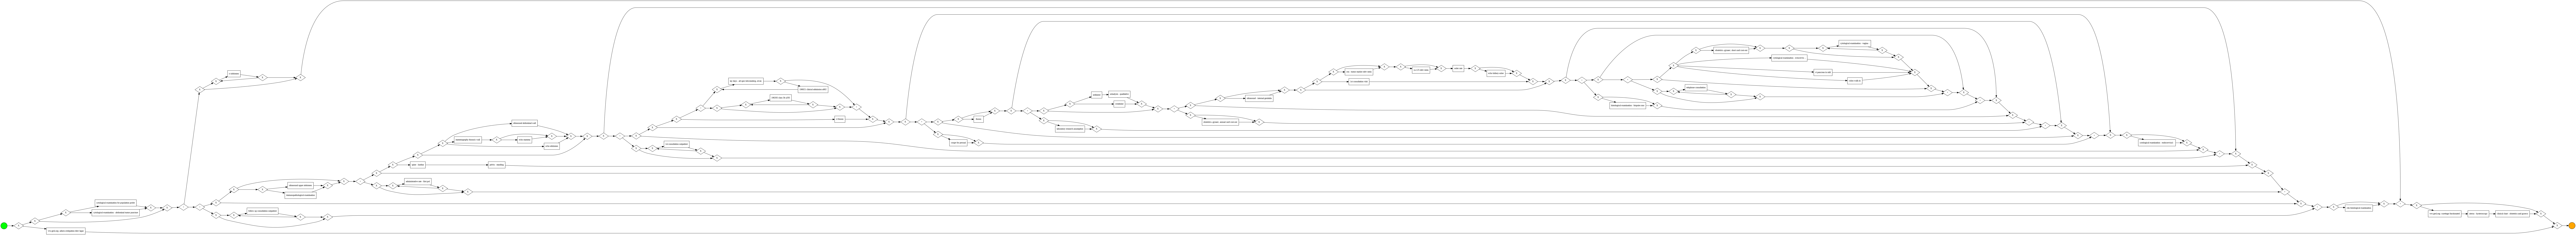

In [67]:
process_tree = pm4py.discover_process_tree_inductive(log=df_for_pm, activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model)

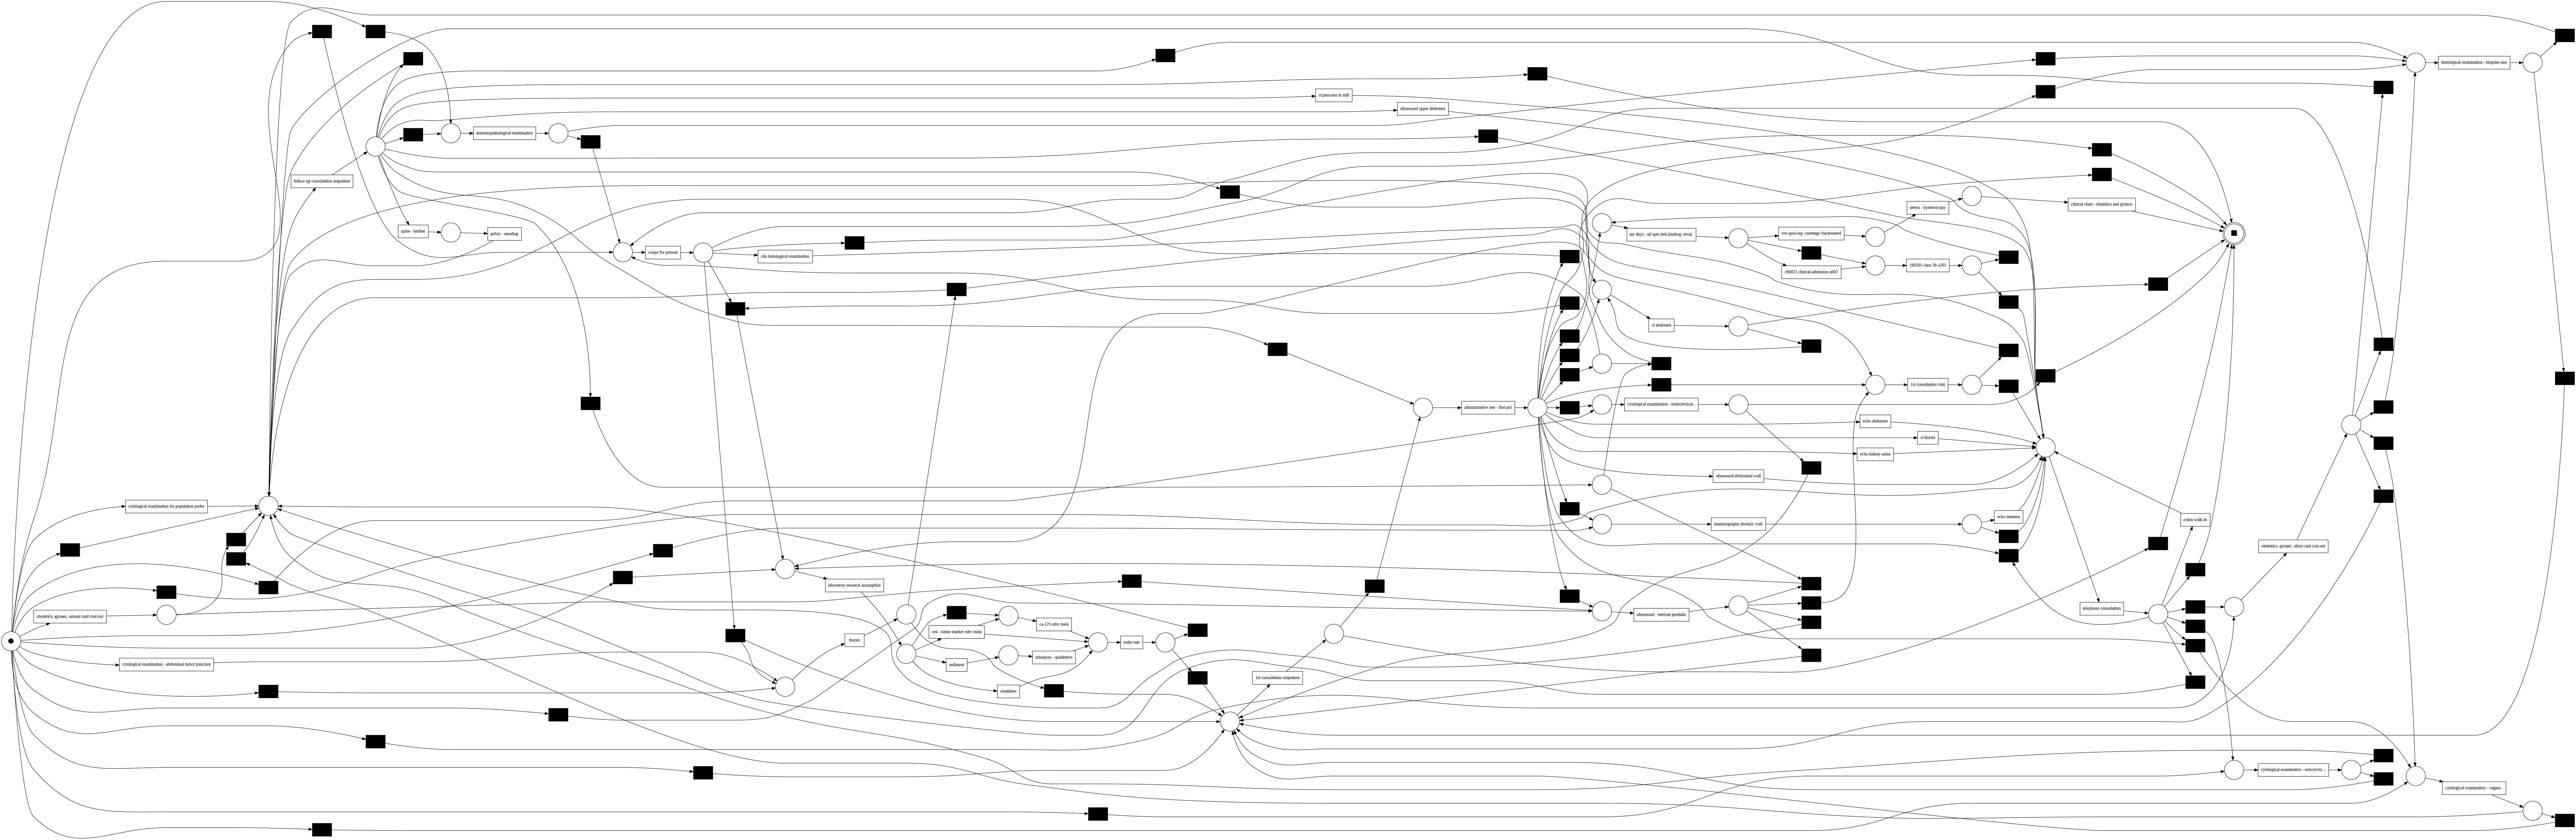

In [68]:
net, im, fm = pm4py.discover_petri_net_heuristics(log=df_for_pm, activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
pm4py.view_petri_net(net, im, fm, format='png')

In [119]:
event_log_modified2 = event_log_modified.copy()
event_log_modified2 = event_log_modified2[['Activity code', 'concept:name']]
event_log_modified2['Activity code'] = event_log_modified2['Activity code'].astype(str)
event_log_modified2['concept:name'] = event_log_modified2['concept:name'].astype(str)
event_log_modified2 = event_log_modified2[['Activity code', 'concept:name']].drop_duplicates()
event_log_modified2.sort_values(by='Activity code', inplace=True)
event_log_modified2

Activity code                                concept:name
2              10107     obstetrics.-gynaec. short card cost-out
75             10113         intern.geneesk. short card cost-out
467            10207        verlosk.-gynaec. aanv.kaart cost-out
261            10213         intern.geneesk. aanv.kaart cost-out
1195           10307    obstetrics.-gynaec. annual card cost-out
...              ...                                         ...
111           710170            filtered erythrocyte concentrate
11777        710170B      erythrocytes leukocytes removed bestra
5275          710290          apheresis plasma split fq1 and fq2
127037       801005A                 bandage sling - application
148767        980929  first aid - not seh department - elsewhere

[677 rows x 2 columns]